# Task II: Classical Graph Neural Network (GNN)

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
* Discuss the resulting performance of the 2 chosen architectures.

Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 92.5 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00a 0:00:01


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Using device: cuda
Loading dataset...
Dataset loaded: Feature shape (100000, 139, 4), Label shape (100000,)
Converting jets to graphs using k-nearest neighbors...
Created 30000 graphs in 47.62 seconds
Example graph info: 45 nodes, 360 edges
Node feature dimensions: torch.Size([45, 4])
Edge feature dimensions: torch.Size([360, 3])
Training graphs: 24000, Testing graphs: 6000

Training GCN model...
GCN Epoch 1/20: Loss=0.5578, Train Acc=0.7164, Test Acc=0.7772, F1=0.7698, Time=4.82s
GCN Epoch 2/20: Loss=0.4811, Train Acc=0.7833, Test Acc=0.7877, F1=0.7839, Time=4.09s
GCN Epoch 3/20: Loss=0.4696, Train Acc=0.7893, Test Acc=0.7877, F1=0.7819, Time=3.98s
GCN Epoch 4/20: Loss=0.4679, Train Acc=0.7879, Test Acc=0.7970, F1=0.7925, Time=3.95s
GCN Epoch 5/20: Loss=0.4637, Train Acc=0.7926, Test Acc=0.7948, F1=0.7910, Time=4.01s
GCN Epoch 6/20: Loss=0.4628, Train Acc=0.7924, Test Acc=0.7935, F1=0.7887, Time=3.99s
GCN Epoch 7/20: Loss=0.4606, Train Acc=0.7940, Test Acc=0.7928, F1=0.7884, Time=3.96

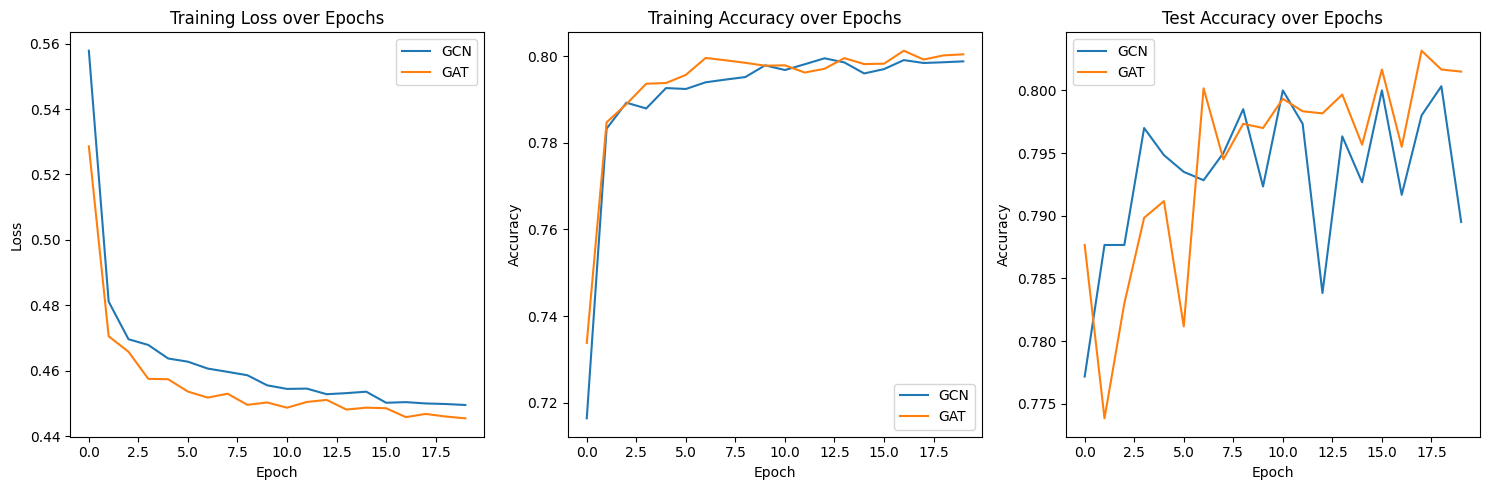

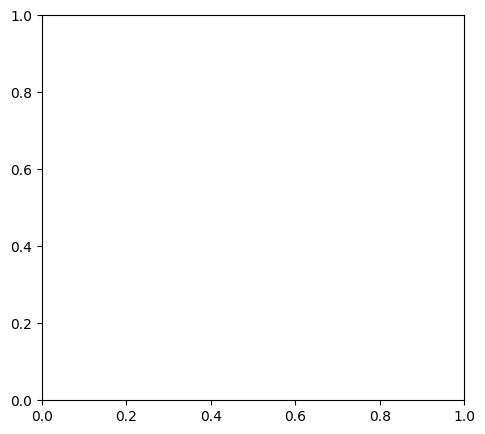

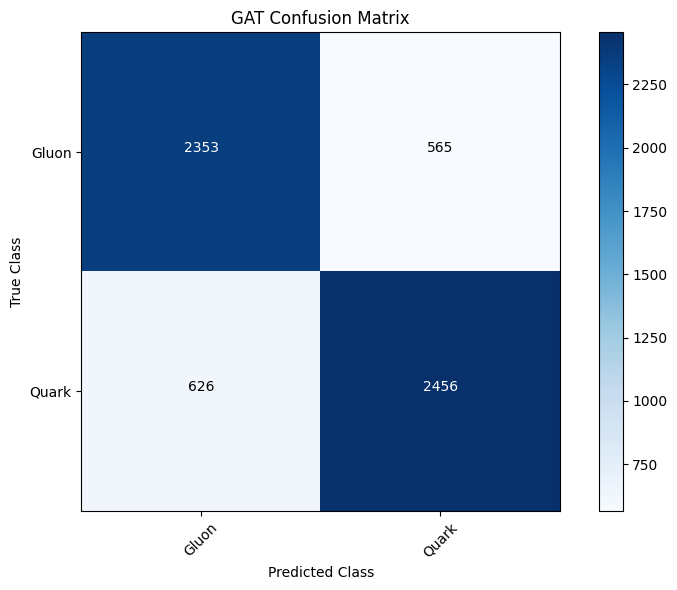

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install numpy matplotlib scikit-learn

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Updated import
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")


# For keeping experiments consistent
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset from file
def load_jet_data(file_path):
    data = np.load(file_path)
    jet_features = data['X']  # Data is (num_samples, max_particles, features)
    jet_labels = data['y']  # Labels for each jet (gluon or quark)
    return jet_features, jet_labels

# Convert particle type IDs to simpler numbers
def simplify_particle_ids(particle_ids):
    """
    Create a simpler numeric encoding for particle IDs.
    Groups basic particle types: quarks (1-6), gluon (21), etc.
    """
    # Mapping from common particle IDs to simple categories
    particle_id_map = {
        1: 1,    # down quark
        2: 2,    # up quark
        3: 3,    # strange quark
        4: 4,    # charm quark
        5: 5,    # bottom quark
        6: 6,    # top quark
        21: 7,   # gluon
        11: 8,   # electron
        13: 9,   # muon
        15: 10,  # tau
        22: 11,  # photon
    }

    # Start with a default category (0) for unknown particles
    encoded_ids = np.zeros_like(particle_ids)

    # Assign categories to known particle types
    for particle_id, category in particle_id_map.items():
        encoded_ids[np.abs(particle_ids) == particle_id] = category

    return encoded_ids

# Turn jet data into graphs with physics-based info
def create_jet_graphs(jet_features, jet_labels, knn_neighbors=5):
    """
    Transform jet point clouds into graph structures.

    Args:
        jet_features: array (n_samples, max_particles, 4) with particle info
        jet_labels: array (n_samples,) with labels (0 for gluon, 1 for quark)
        knn_neighbors: number of nearest neighbors for graph building
    """
    graphs = []

    for i in range(len(jet_features)):
        # Remove particles added as padding (zeros)
        particle_mask = np.sum(jet_features[i], axis=1) != 0
        particles = jet_features[i][particle_mask]

        if len(particles) <= 1:  # Need at least 2 particles to make a graph
            continue

        # Get particle properties
        pt = particles[:, 0]         # Transverse momentum (how fast particle moves across beam)
        rapidity = particles[:, 1]   # Rapidity (related to angle from beam)
        phi = particles[:, 2]        # Azimuthal angle (angle around beam)
        particle_id = particles[:, 3] # Particle type ID

        # Encode particle types
        encoded_particle_ids = simplify_particle_ids(particle_id)

        # Create node features
        log_pt = np.log1p(pt)  # log(1+pt) to handle small values and focus on softer particles

        # Node features: log(pt), rapidity, phi, encoded particle ID
        node_features = np.column_stack([log_pt, rapidity, phi, encoded_particle_ids])
        node_features = torch.tensor(node_features, dtype=torch.float)

        # Connect particles using k-nearest neighbors based on distance in detector view (delta R)
        edge_connections = []
        edge_attributes = []  # Edge info: delta_r, delta_phi, pt_ratio

        for j in range(len(particles)):
            # Calculate detector distance (delta R) to all other particles
            delta_phi_values = phi - phi[j]
            # Keep angle difference within -pi to pi
            delta_phi_values = np.mod(delta_phi_values + np.pi, 2 * np.pi) - np.pi
            delta_r_values = np.sqrt(delta_phi_values**2 + (rapidity - rapidity[j])**2)

            # Find indices of k nearest particles (excluding itself)
            nearest_particle_indices = np.argsort(delta_r_values)[1:knn_neighbors+1] # Skip self

            for index in nearest_particle_indices:
                edge_connections.append([j, index])

                # Physics-motivated edge features
                pt_ratio = min(pt[j], pt[index]) / max(pt[j], pt[index]) # Momentum ratio
                edge_attributes.append([delta_r_values[index], delta_phi_values[index], pt_ratio])

        if not edge_connections:  # If no edges are formed (e.g., only one particle left after filtering)
            continue

        edge_connections = torch.tensor(edge_connections, dtype=torch.long).t().contiguous()
        edge_attributes = torch.tensor(edge_attributes, dtype=torch.float)

        # Make PyTorch Geometric graph data object
        graph_data = Data(
            x=node_features,
            edge_index=edge_connections,
            edge_attr=edge_attributes,
            y=torch.tensor([jet_labels[i]], dtype=torch.long)
        )

        graphs.append(graph_data)

    return graphs

# Define Graph Convolutional Network (GCN) model
class PhysicsGCN(nn.Module):
    def __init__(self, node_feature_dimension, edge_feature_dimension, hidden_layer_size=64, output_dimension=2):
        super(PhysicsGCN, self).__init__()
        # Process initial node features
        self.node_feature_processor = nn.Sequential(
            nn.Linear(node_feature_dimension, hidden_layer_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer_size)
        )

        # Graph Convolution Layers
        self.graph_conv1 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.graph_conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.graph_conv3 = GCNConv(hidden_layer_size, hidden_layer_size)

        # Output layers to classify
        self.fully_connected1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fully_connected2 = nn.Linear(hidden_layer_size, output_dimension)

        # Batch Normalization for layers
        self.batch_norm1 = nn.BatchNorm1d(hidden_layer_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_layer_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_layer_size)

    def forward(self, data):
        x, edge_index, batch_indices = data.x, data.edge_index, data.batch

        # Encode node features initially
        x = self.node_feature_processor(x)

        # Apply Graph Convolutional layers with activations and dropout
        x = F.relu(self.batch_norm1(self.graph_conv1(x, edge_index)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.batch_norm2(self.graph_conv2(x, edge_index)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.batch_norm3(self.graph_conv3(x, edge_index)))

        # Pool node features to get graph-level representation (for jet classification)
        x = global_mean_pool(x, batch_indices)

        # Fully connected layers for classification
        x = F.relu(self.fully_connected1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fully_connected2(x)

        return F.log_softmax(x, dim=1) # Log-softmax for classification

# Define Graph Attention Network (GAT) model
class PhysicsGAT(nn.Module):
    def __init__(self, node_feature_dimension, edge_feature_dimension, hidden_layer_size=64, output_dimension=2, attention_heads=4):
        super(PhysicsGAT, self).__init__()
        # Node feature processing at start
        self.node_feature_processor = nn.Sequential(
            nn.Linear(node_feature_dimension, hidden_layer_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer_size)
        )

        # Graph Attention Layers
        self.graph_attention1 = GATConv(hidden_layer_size, hidden_layer_size // attention_heads, heads=attention_heads)
        self.graph_attention2 = GATConv(hidden_layer_size, hidden_layer_size // attention_heads, heads=attention_heads)
        self.graph_attention3 = GATConv(hidden_layer_size, hidden_layer_size, heads=1) # Last layer, single head

        # Output classification layers
        self.fully_connected1 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fully_connected2 = nn.Linear(hidden_layer_size, output_dimension)

        # Batch Normalization for layers
        self.batch_norm1 = nn.BatchNorm1d(hidden_layer_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_layer_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_layer_size)

    def forward(self, data):
        x, edge_index, batch_indices = data.x, data.edge_index, data.batch

        # Initial node feature encoding
        x = self.node_feature_processor(x)

        # Apply Graph Attention Layers
        x = F.relu(self.batch_norm1(self.graph_attention1(x, edge_index)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.batch_norm2(self.graph_attention2(x, edge_index)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.batch_norm3(self.graph_attention3(x, edge_index)))

        # Global pooling (mean pooling for jets)
        x = global_mean_pool(x, batch_indices)

        # Classification layers
        x = F.relu(self.fully_connected1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fully_connected2(x)

        return F.log_softmax(x, dim=1) # Output log probabilities

# Function to train the model
def train_model(model, data_loader, optimiser, device_name):
    model.train() # Set model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for graph_batch in data_loader:
        graph_batch = graph_batch.to(device_name) # Move data to device
        optimiser.zero_grad() # Clear gradients
        output = model(graph_batch) # Model prediction
        loss = F.nll_loss(output, graph_batch.y) # Calculate loss
        loss.backward() # Backpropagate gradients
        optimiser.step() # Update model parameters

        total_loss += loss.item() * graph_batch.num_graphs # Accumulate loss
        predicted_class = output.max(dim=1)[1] # Get predicted class
        correct_predictions += predicted_class.eq(graph_batch.y).sum().item() # Count correct
        total_samples += graph_batch.y.size(0) # Count total samples

    return total_loss / len(data_loader.dataset), correct_predictions / total_samples # Avg loss, accuracy

# Function to evaluate model performance
def evaluate_model(model, data_loader, device_name):
    model.eval() # Set model to evaluation mode
    all_predictions = []
    actual_labels = []

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for graph_batch in data_loader:
            graph_batch = graph_batch.to(device_name) # Move data to device
            output = model(graph_batch) # Get model output
            predicted_class = output.max(dim=1)[1] # Determine predicted class
            all_predictions.extend(predicted_class.cpu().numpy()) # Store predictions
            actual_labels.extend(graph_batch.y.cpu().numpy()) # Store actual labels

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, all_predictions)
    roc_auc = roc_auc_score(actual_labels, all_predictions)
    precision = precision_score(actual_labels, all_predictions)
    recall = recall_score(actual_labels, all_predictions)
    f1 = f1_score(actual_labels, all_predictions)
    confusion_matrix_val = confusion_matrix(actual_labels, all_predictions)

    return { # Return metrics in a dictionary
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix_val
    }

# Function to visualize confusion matrix
def plot_confusion_matrix_custom(conf_matrix, class_names, title='Confusion Matrix', colormap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=colormap) # Display matrix as image
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45) # X ticks with class names
    plt.yticks(tick_marks, class_names) # Y ticks with class names

    text_format = 'd' # Format for numbers in matrix
    threshold = conf_matrix.max() / 2. # Threshold to decide text color

    # Add numbers to each cell in matrix
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], text_format),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > threshold else "black") # Text color based on threshold

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    return plt

# Main function to run everything
def main_process():
    # Determine device: GPU if available, CPU otherwise
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    print("Loading dataset...")
    file_path = '/kaggle/input/qg-jets/QG_jets.npz'
    jet_particles, jet_type_labels = load_jet_data(file_path)
    print(f"Dataset loaded: Feature shape {jet_particles.shape}, Label shape {jet_type_labels.shape}")

    # Use a smaller dataset for faster runs if needed
    sample_size = 30000  # Adjust this to use more or less data
    random_indices = np.random.choice(len(jet_particles), sample_size, replace=False)
    subset_jet_particles = jet_particles[random_indices]
    subset_jet_labels = jet_type_labels[random_indices]

    # Convert jet data to graph format
    print("Converting jets to graphs using k-nearest neighbors...")
    start_time_conversion = time.time()
    num_nearest_neighbors = 8 # How many neighbors to connect each particle to
    graph_dataset = create_jet_graphs(subset_jet_particles, subset_jet_labels, knn_neighbors=num_nearest_neighbors)
    conversion_duration = time.time() - start_time_conversion
    print(f"Created {len(graph_dataset)} graphs in {conversion_duration:.2f} seconds")

    # Show info about example graph
    example_graph = graph_dataset[0]
    print(f"Example graph info: {len(example_graph.x)} nodes, {example_graph.edge_index.shape[1]} edges")
    print(f"Node feature dimensions: {example_graph.x.shape}")
    print(f"Edge feature dimensions: {example_graph.edge_attr.shape}")

    # Split graphs into training and testing sets
    training_graphs, testing_graphs = train_test_split(graph_dataset, test_size=0.2, random_state=42)
    print(f"Training graphs: {len(training_graphs)}, Testing graphs: {len(testing_graphs)}")

    # Create data loaders for training and testing
    data_batch_size = 64
    training_data_loader = DataLoader(training_graphs, batch_size=data_batch_size, shuffle=True)
    testing_data_loader = DataLoader(testing_graphs, batch_size=data_batch_size, shuffle=False)

    # Initialize GCN and GAT models
    node_feature_dimension = example_graph.x.shape[1] # Number of node features
    edge_feature_dimension = example_graph.edge_attr.shape[1] # Number of edge features
    hidden_layer_size = 128 # Size of hidden layers in models

    gcn_network = PhysicsGCN(node_feature_dimension, edge_feature_dimension, hidden_layer_size=hidden_layer_size).to(device)
    gat_network = PhysicsGAT(node_feature_dimension, edge_feature_dimension, hidden_layer_size=hidden_layer_size, attention_heads=4).to(device)

    # Set up optimizers for both models
    gcn_optimiser = torch.optim.Adam(gcn_network.parameters(), lr=0.001, weight_decay=5e-4)
    gat_optimiser = torch.optim.Adam(gat_network.parameters(), lr=0.001, weight_decay=5e-4)

    # Train and evaluate GCN model
    print("\nTraining GCN model...")
    gcn_training_losses = []
    gcn_training_accuracies = []
    gcn_testing_metrics = []

    number_of_epochs = 20 # How many times to go through the dataset
    for epoch in range(number_of_epochs):
        start_time_epoch = time.time()
        train_loss, train_accuracy = train_model(gcn_network, training_data_loader, gcn_optimiser, device)
        test_metrics = evaluate_model(gcn_network, testing_data_loader, device)
        epoch_duration = time.time() - start_time_epoch

        # Store metrics from this epoch
        gcn_training_losses.append(train_loss)
        gcn_training_accuracies.append(train_accuracy)
        gcn_testing_metrics.append(test_metrics)

        print(f"GCN Epoch {epoch+1}/{number_of_epochs}: "
              f"Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"F1={test_metrics['f1']:.4f}, "
              f"Time={epoch_duration:.2f}s")

    # Train and evaluate GAT model
    print("\nTraining GAT model...")
    gat_training_losses = []
    gat_training_accuracies = []
    gat_testing_metrics = []

    for epoch in range(number_of_epochs):
        start_time_epoch = time.time()
        train_loss, train_accuracy = train_model(gat_network, training_data_loader, gat_optimiser, device)
        test_metrics = evaluate_model(gat_network, testing_data_loader, device)
        epoch_duration = time.time() - start_time_epoch

        # Save epoch metrics
        gat_training_losses.append(train_loss)
        gat_training_accuracies.append(train_accuracy)
        gat_testing_metrics.append(test_metrics)

        print(f"GAT Epoch {epoch+1}/{number_of_epochs}: "
              f"Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
              f"Test Acc={test_metrics['accuracy']:.4f}, "
              f"F1={test_metrics['f1']:.4f}, "
              f"Time={epoch_duration:.2f}s")

    # Compare GCN and GAT results
    print("\nModel Comparison:")
    print("GCN Performance:")
    for metric_name, metric_value in gcn_testing_metrics[-1].items():
        if metric_name != 'confusion_matrix': # Don't print confusion matrix here
            print(f"  {metric_name}: {metric_value:.4f}")

    print("\nGAT Performance:")
    for metric_name, metric_value in gat_testing_metrics[-1].items():
        if metric_name != 'confusion_matrix': # Avoid printing matrix in comparison
            print(f"  {metric_name}: {metric_value:.4f}")

    # Visualize training and test performance over epochs
    plt.figure(figsize=(15, 5))

    # Plot training loss for both models
    plt.subplot(1, 3, 1)
    plt.plot(gcn_training_losses, label='GCN')
    plt.plot(gat_training_losses, label='GAT')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 3, 2)
    plt.plot(gcn_training_accuracies, label='GCN')
    plt.plot(gat_training_accuracies, label='GAT')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 3, 3)
    gcn_test_accuracies = [metric_values['accuracy'] for metric_values in gcn_testing_metrics]
    gat_test_accuracies = [metric_values['accuracy'] for metric_values in gat_testing_metrics]
    plt.plot(gcn_test_accuracies, label='GCN')
    plt.plot(gat_test_accuracies, label='GAT')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig('gnn_learning_curves.png') # Save learning curves

    # Plot confusion matrices for final epoch
    class_labels = ['Gluon', 'Quark'] # Class names for confusion matrix

    plt.figure(figsize=(12, 5))

    # plt.subplot(1, 2, 1)
    # plot_confusion_matrix_custom(gcn_testing_metrics[-1]['confusion_matrix'], class_names=class_labels, title='GCN Confusion Matrix')

    plt.subplot(1, 2, 2)
    plot_confusion_matrix_custom(gat_testing_metrics[-1]['confusion_matrix'], class_names=class_labels, title='GAT Confusion Matrix')

    plt.tight_layout()
    plt.savefig('gnn_confusion_matrices.png') # Save confusion matrices

    print("Finished! Check saved images for results.")

if __name__ == "__main__":
    main_process()